In [78]:
from sklearn.model_selection import (
        train_test_split,
        KFold, 
        cross_validate,
        GridSearchCV)

from sklearn.linear_model import (
        Ridge,
        LinearRegression, 
        ElasticNet)


import matplotlib.pyplot as plt


import pandas as pd
import geopandas as gpd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import (
        StandardScaler,
        OneHotEncoder, 
        PowerTransformer, 
        OrdinalEncoder,
        QuantileTransformer,
        PolynomialFeatures, 
        RobustScaler)

from sklearn.dummy import DummyRegressor
from src.config import DADOS_TRATADOS

from src.utils import treinar_e_validar_modelo_regressao, treinar_e_validar_modelo_regressao_grid_search, organiza_resultados

from src.graph import plot_model_metrics

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
outlier_cols = df.select_dtypes('number').skew().abs()
outlier_cols = outlier_cols[outlier_cols > 0.5].index.tolist()  

In [5]:
target_cols  = ['median_house_value']

cols_power = outlier_cols

cols_power.remove('median_house_value')

cols_ordinal = ['median_income_cat']

cols_ohe = ['ocean_proximity']

cols_standard = ['longitude', 'latitude', 'housing_median_age']

cols_robust = df.columns.difference(target_cols + cols_ordinal + cols_ohe)

In [6]:
cols_group = {
    "standard": cols_standard,
    "ohe": cols_ohe,
    "robust": cols_robust,
    "target": target_cols,
    "power": cols_power,
    "ordinal": cols_ordinal
}

In [7]:
preprocessor_cat = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories='auto'), cols_group['ordinal']),
        ('ohe', OneHotEncoder(drop='first'), cols_group['ohe'])],
    remainder='passthrough')

preprocessor_simple = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories='auto'), cols_group['ordinal']),
        ('ohe', OneHotEncoder(drop='first'), cols_group['ohe']),
        ('robust', RobustScaler(), cols_group['robust']),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories='auto'), cols_group['ordinal']),
        ('ohe', OneHotEncoder(drop='first'), cols_group['ohe']),
        ('power', PowerTransformer(), cols_group['power']),
        ('standard', StandardScaler(), cols_group['standard']),
    ]
)

In [48]:
param_grid = {'regressor__preprocessor': [preprocessor, preprocessor_cat, preprocessor_simple],
             "transformer": [None, QuantileTransformer(output_distribution='normal'), PowerTransformer()]}

grid_search = treinar_e_validar_modelo_regressao_grid_search(
    LinearRegression(),
    param_grid=param_grid,
    preprocessor=preprocessor
)

,estimator,Pipeline(step...egression())])
,param_grid,"{'regressor__preprocessor': [ColumnTransfo...edian_age'])]), ColumnTransfo...proximity'])]), ...], 'transformer': [None, QuantileTrans...tion='normal'), ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal', ...), ('ohe', ...), ...]"


In [9]:
X = df.drop(columns=cols_group['target'])
y = df[cols_group['target']]

In [10]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,TransformedTa...Transformer())
,param_grid,"{'regressor__preprocessor': [ColumnTransfo...edian_age'])]), ColumnTransfo...proximity'])]), ...], 'transformer': [None, QuantileTrans...tion='normal'), ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal', ...), ('ohe', ...), ...]"


In [11]:
grid_search.best_estimator_

,regressor,Pipeline(step...egression())])
,transformer,QuantileTrans...tion='normal')
,func,None
,inverse_func,None
,check_inverse,True
,transformers,"[('ordinal', ...), ('ohe', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [12]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                  ['median_income_cat']),
                                 ('ohe', OneHotEncoder(drop='first'),
                                  ['ocean_proximity']),
                                 ('robust', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

In [58]:
pipe_robust = Pipeline([('robust', RobustScaler()), ("poly", PolynomialFeatures(degree=1, include_bias=False))])

preprocessor_with_robust_poly = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), cols_group['ordinal']),
        ("one_hot", OneHotEncoder(drop="first"), cols_group['ohe']),
        ("robust_scaler_poly", pipe_robust, cols_group['robust']),
    ],
)

param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0],
    "regressor__reg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

grid_search_elastic_net = treinar_e_validar_modelo_regressao_grid_search(
    regressor=ElasticNet(),
    preprocessor=preprocessor_with_robust_poly,
    param_grid=param_grid,
    target_transformer=QuantileTransformer(output_distribution='normal'),
)

In [59]:
grid_search_elastic_net.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/home/gustavomundim/anaconda3/envs/machine_learning/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.839e+00, tolerance: 1.427e+00
  model = cd_fast.enet_coordinate_descent(
/home/gustavomundim/anaconda3/envs/machine_learning/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.821e+01, tolerance: 1.431e+00
  model = cd_fast.enet_coordinate_descent(
/home/gustavomundim/anaconda3/envs/machine_learning/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

,estimator,TransformedTa...ion='normal'))
,param_grid,"{'regressor__preprocesso...aler_poly__poly__degree': [1, 2, ...], 'regressor__reg__alpha': [0.01, 0.05, ...], 'regressor__reg__l1_ratio': [0.1, 0.25, ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal_encoder', ...), ('one_hot', ...), ...]"


In [61]:
grid_search_elastic_net.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

In [63]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0],
}


grid_search_ridge = treinar_e_validar_modelo_regressao_grid_search(
    regressor=Ridge(),
    preprocessor=preprocessor_with_robust_poly,
    param_grid=param_grid,
    target_transformer=QuantileTransformer(output_distribution='normal'),
)

In [64]:
grid_search_ridge.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,TransformedTa...ion='normal'))
,param_grid,"{'regressor__preprocesso...aler_poly__poly__degree': [1, 2, ...], 'regressor__reg__alpha': [0.01, 0.05, ...]}"
,scoring,"['r2', 'neg_mean_absolute_error', ...]"
,n_jobs,-1
,refit,'neg_root_mean_squared_error'
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal_encoder', ...), ('one_hot', ...), ...]"


In [65]:
grid_search_ridge.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 1.0}

In [67]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(),
        "target_transformer": None
    },
    "LinearRegression": {
        "preprocessor": preprocessor_cat,
        "regressor": LinearRegression(),
        "target_transformer": None
    },
    "LinearRegression_target": {
        "preprocessor": preprocessor,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution='normal')
    },
    "Ridge_grid_search": {
        "preprocessor": grid_search_ridge.best_estimator_.regressor_['preprocessor'],
        "regressor": grid_search_ridge.best_estimator_.regressor_['reg'],
        "target_transformer": grid_search_ridge.best_estimator_.transformer_
    },
}

In [69]:
resultado = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

In [75]:
df_resultado = organiza_resultados(resultado)

In [77]:
df_resultado.groupby(['model']).mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.002955,0.003495,-0.000436,-76702.495836,-95975.447913,0.006449
LinearRegression,0.015848,0.005823,0.668059,-40780.260916,-55276.769391,0.02167
LinearRegression_target,0.165682,0.007835,0.670813,-39321.444471,-55040.763254,0.173517
Ridge_grid_search,0.097879,0.014199,0.720989,-35375.326844,-50666.991324,0.112078


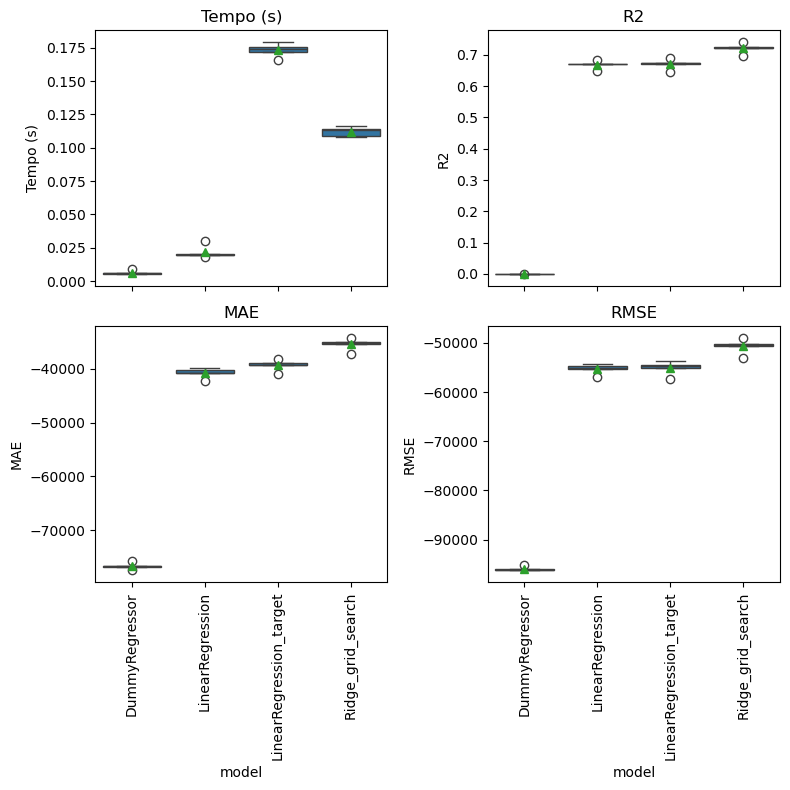

In [79]:
plot_model_metrics(df_resultado)

In [ ]:
dump(grid_search_ridge.best_estimator_, )